****This is a work on the credit card Fraud detection dataset. The case is of an imbalanced dataset where the no. of Frauds is obviously very less compared to the genuine transactions. Our motive  is to improve the precision/ recall scores.
A high recall score can be obtained by fine tuning the model which'll see in the later parts but precision improvement is challenging task because Precision =( *TP/ FP + TP*  )FP can be very high because a large no. of Genuine transactions can be labeled as Fraud.  Recall ( *TP/TP +FN*)  .It is desirable to have high recall scores so that FN (Frauds labeled as genuine) are minimized. 


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn 
import seaborn as sns
import matplotlib.pyplot as plt
import imblearn
from sklearn.model_selection import GridSearchCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
data=pd.read_csv(r'''../input/creditcard.csv''')
data


In [ ]:
data.describe()
data.isnull().any().max()
#no null values in our dataset

The measure of imbalance can be seen when we plot  a percentage ratio of the target data

In [ ]:
print('No Frauds', round(len(data[data["Class"]==0])/len(data)*100, 2))
print('Frauds', round(len(data[data["Class"]==1])/len(data)*100, 2))

In [ ]:
#case of a classic imbalanced dataset, a classifier always predicting 0 wil also predict with an accuracy of 99.83%
sns.countplot('Class', data=data)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)
plt.show()

In [ ]:
#next up, we are going to scale the values of time and amount, because all the other columns V1: V27 are scaled
from sklearn.preprocessing import RobustScaler
#RobustScaler are less prone to outliers
rcf= RobustScaler()
data["scaled_amount"]= rcf.fit_transform(data["Amount"].values.reshape(-1,1))
data["scaled_time"]= rcf.fit_transform(data["Time"].values.reshape(-1,1))
data= data.drop(["Time", "Amount"] ,axis =1 )
data

In [ ]:
scaled_amount = data['scaled_amount']
scaled_time = data['scaled_time']

data.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
data.insert(0, 'scaled_amount', scaled_amount)
data.insert(1, 'scaled_time', scaled_time)
labels = data.columns

In [ ]:
X= data.drop('Class', axis=1)
y=data["Class"]

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, random_state= 0)


For an imbalanced set , the very first task after scaling the values, was to split the data into training & test set, and keeping test set untouched. Post this , we are now going to re-sample our data set by the means of SMOTE (Synthetic Minority Oversampling Technique) .The reason behind splitting our data first is because if we resample our dataset before splitting our test set might become biased towards some particular features which we used to generate samples, this would overfit the model.


 
SMOTE (Synthetic Minority Oversampling TEchnique) consists of synthesizing elements for the minority class, based on those that already exist. It works randomly picingk a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors. The link provided below introduced me to a number of sampling strategies
https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets# 

In [ ]:
from imblearn.over_sampling import SMOTE
def sampling_func(X, y):
    smote= SMOTE( ratio= 'minority')
    x_sm, y_sm= smote.fit_sample(X, y)
    return x_sm, y_sm
    


In [ ]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

In [ ]:
X_sampled, y_sampled = sampling_func(X_train, y_train)
plot_2d_space(X_sampled, y_sampled, 'SMOTE oversampled data')


In [ ]:
X_sampled= pd.DataFrame(X_sampled)
y_Sampled= pd.DataFrame(y_sampled)
df= pd.concat([X_sampled, y_Sampled], axis= 1)
df.columns
df.columns= data.columns
df

In [ ]:
colors = ["#0101DF", "#DF0101"]
sns.countplot('Class', data=df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

The  seaborn countplot helps us plot the dataset in terms of the proportion of Fraud and genuine transactions. Post sampling, we can see that our dataset is now equally distributed.

Post sampling, we'll do some more data cleaning and visualization. Lets plot a correlation heatmap to see the features which have a strong influence on the target variable of our dataset. We'll be using the subsampled space 

In [ ]:
f, ax2 = plt.subplots(1, 1, figsize=(24,20))
sampled_corr = df.corr()
sns.heatmap(sampled_corr, cmap='coolwarm_r', annot_kws={'size':20})
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

The following inferences can be made out out of the matrix: 

1. **Negative Correlations**: V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction. 

2. **Positive Correlations**:  V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. 

Now, we know that these features are instrumental to predicting a Fraud transaction. We'll use boxplot to have a better understanding of the distribution of these features 

In [ ]:

f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')

plt.show()

In [ ]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()


**Anomaly Detection:**

Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models. 

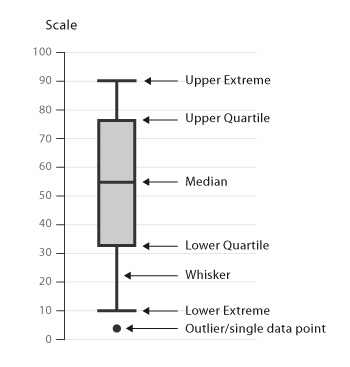]





**Removing outliers**


V14 has  highest  **negative co-relation** when it comes to predicting the target variable. 

In [ ]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = df['V14'].loc[df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.92
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

df = df.drop(df[(df['V14'] > v14_upper) & (df['V14'] < v14_lower)].index)



In [ ]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = df['V14'].loc[df['Class'] == 0].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 5.4
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

df = df.drop(df[(df['V14'] > v14_upper) & (df['V14'] < v14_lower)].index)



Now , V4 has the highest **positive co-relation** in the dataset to predict the  class.  We will be performing the same steps as in the previous case. But V4 seems to have no outliers wehn observing the box-plot. So, we will be using V11 which has the next best correlation  to find and remove the outliers from the dataset. 

In [ ]:
# # -----> V11 Removing Outliers (Highest Positive Correlated with Labels)
# Removing outliers i genuine cases
v11_fraud = df['V11'].loc[df['Class'] == 0].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('iqr: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 2
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut Off: {}'.format(v11_cut_off))
print('V11 Lower: {}'.format(v11_lower))
print('V11 Upper: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V11 outliers:{}'.format(outliers))

df = df.drop(df[(df['V11'] > v11_upper) & (df['V11'] < v11_lower)].index)


In [ ]:
# # -----> V11 Removing Outliers (Highest Postive Correlated with Labels)
# Removing outliers in genuine target cases
v11_fraud = df['V11'].loc[df['Class'] == 1].values
q25, q75 = np.percentile(v11_fraud, 25), np.percentile(v11_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v11_iqr = q75 - q25
print('iqr: {}'.format(v11_iqr))

v11_cut_off = v11_iqr * 2.35
v11_lower, v11_upper = q25 - v11_cut_off, q75 + v11_cut_off
print('Cut Off: {}'.format(v11_cut_off))
print('V11 Lower: {}'.format(v11_lower))
print('V11 Upper: {}'.format(v11_upper))

outliers = [x for x in v11_fraud if x < v11_lower or x > v11_upper]
print('Feature V11 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V11 outliers:{}'.format(outliers))

df = df.drop(df[(df['V11'] > v11_upper) & (df['V11'] < v11_lower)].index)

In [ ]:
X_train_final= df.drop('Class', axis=1)
y_train_final=df["Class"] 


In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit_transform(X_train_final)

In [ ]:
explained_variance=pca.explained_variance_ratio_
explained_variance

In [ ]:
with plt.style.context('dark_background'):
    plt.figure(figsize=(10, 10))

    plt.bar(range(30), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
    plt.ylabel('Explained variance ratio')
    plt.xlabel('Principal components')
    plt.legend(loc='best')
    plt.tight_layout()

Nearly 75% of the variance is expressed by thefirst 2 components. We'll be using 5 components because they sufficiently express the variance while creating a  dimensionality reduction and post the 6th components, contribution is less than 1-2%

In [ ]:
pca=PCA(n_components=5)
X_new=pca.fit_transform(X_train_final)
X_train_pca= pd.DataFrame(X_new)
X_train_pca

In [ ]:
X_test_pca= pca.transform(X_test)
X_test_pca= pd.DataFrame(X_test_pca)
X_test_pca

In [ ]:
#from sklearn.ensemble import RandomForestClassifier
#parameters = { 
#    'n_estimators': [200, 500],
#    'max_features': ['auto', 'sqrt', 'log2'],
#    'max_depth' : [4,5,6,7,8],
#   'criterion' :['gini', 'entropy']
#}
#classifier= RandomForestClassifier()
#grid_search= GridSearchCV(estimator=classifier, param_grid=parameters, cv= 5, n_jobs= -1)

In [ ]:
#using Logistic Regression to classify the tweets 

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
parameters = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(estimator= classifier,param_grid= parameters, cv=5,  n_jobs= -1)

In [ ]:

#from sklearn import svm, datasets
#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
#svc = svm.SVC()
#grid_search = GridSearchCV(estimator= svc, param_grid= parameters, cv=5, n_jobs= -1)

In [ ]:


from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, classification_report



    

In [ ]:
grid_search.fit(X_train_pca, y_train_final)


    

In [ ]:
y_pred = grid_search.predict(X_test_pca)

In [ ]:
cm= confusion_matrix(y_test, y_pred)
labels = ['Not relevant', 'Relevant']
print(classification_report(y_test, y_pred, target_names=labels))

In [ ]:
cm

In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense


In [ ]:
#creating an object of sequential class
classifier= Sequential()


In [ ]:
n_inputs= X_train_pca.shape[1]

#now we'll use methods of the object to add layers in our neural network model
classifier.add(Dense(output_dim = 3, init='uniform' , activation = 'relu', input_dim = n_inputs))
classifier.add(Dense(output_dim = 1, init='uniform' , activation = 'softmax'))



In [ ]:
#compile the ANN model
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy']) 

In [ ]:
#fit the ANN model
classifier.fit(X_train_pca, y_train_final, batch_size= 10, nb_epoch= 100)


In [ ]:
#prediction on test set
y_pred = classifier.predict(X_test_pca)
       

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred>0.5)
cm
labels = ['Not relevant', 'Relevant']
print(classification_report(y_test, y_pred>0.5, target_names=labels))